In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from production.loop_updates import loop_update, get_loops
from production import Problem, ExactSolver, Worldline, local_move
from production.utils import draw_key, GridUnionFind
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
rng = np.random.default_rng(7)

In [1]:
pb = Problem(n_sites=8, J_x=10.0, J_z=1.0, temperature=10, m=4)
pb.delta_tau

NameError: name 'Problem' is not defined

In [8]:
solver = ExactSolver(pb)
solver.energy

np.complex128(-2.0198250150668224+0j)

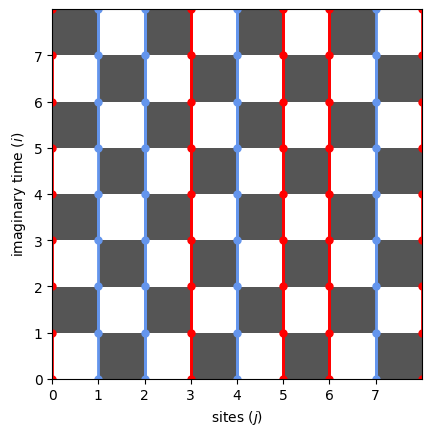

In [9]:
spins = np.ones((2 * pb.m, pb.n_sites))
for i in range(0, pb.n_sites, 2):
    spins[:, i] *= -1
wl = Worldline(pb, spins)
for _ in range(1_000):
    local_move(wl, rng)
wl.draw()

2


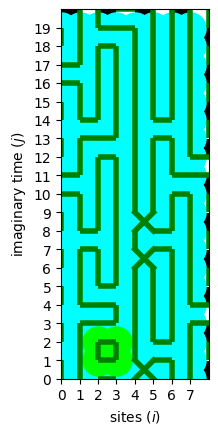

In [7]:
n = wl.problem.n_sites
m = wl.problem.m

plt.xticks(range(n))
plt.yticks(range(2 * m))
# plt.grid()
plt.xlim(0, n)
plt.ylim(0, 2 * m)

ax = plt.gca()
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("sites ($i$)")
ax.set_ylabel("imaginary time ($j$)")

tiles = np.zeros((2 * m, n))
for j in range(2 * m):
    for i in range(n):
        tiles[j, i] = (
            i + j % 2 + 1
        ) % 2  # checkerboard pattern for better visibility

plt.imshow(
    tiles,
    cmap="gray",
    interpolation="nearest",
    vmin=0,
    vmax=1,
    extent=(0, n, 2 * m, 0),
)

spins = wl.spins

uf = GridUnionFind(m, n)

probs = wl.problem.calculate_general_probabilities()

for j in range(2 * m):
    for base_i in range(n // 2):
        i = 2 * base_i + (j % 2)

        j_plus = (j + 1) % (2 * m)
        i_plus = (i + 1) % n

        if spins[j, i] != spins[j_plus, i]:  # cross, S2
            key = draw_key(probs["S2"], rng)
            if key == "G2":
                # print(f"{i},{j} -> 2 ({probs["S2"]["G2"]})")
                plt.hlines([j, j + 1], i, i + 1, color="green", linewidth=4)
                uf.union(j, i, j, i_plus)
                uf.union(j_plus, i, j_plus, i_plus)
            elif key == "G4":
                # print(f"{i},{j} -> 4 ({probs["S2"]["G4"]})")
                plt.plot([i, i + 1], [j, j + 1], color="green", linewidth=4)
                plt.plot([i, i + 1], [j + 1, j], color="green", linewidth=4)
                uf.union(j, i, j_plus, i_plus)
                uf.union(j, i_plus, j_plus, i)
            else:
                print("aïe G3")
        elif spins[j, i] != spins[j, i_plus]:  # side, S1
            key = draw_key(probs["S1"])
            if key == "G1":
                plt.vlines([i, i + 1], j, j + 1, color="green", linewidth=4)
                # print(f"{i},{j} -> 1 ({probs["S1"]["G1"]})")
                uf.union(j, i, j_plus, i)
                uf.union(j, i_plus, j_plus, i_plus)
            elif key == "G2":
                plt.hlines([j, j + 1], i, i + 1, color="green", linewidth=4)
                # print(f"{i},{j} -> 2 ({probs["S1"]["G2"]})")
                uf.union(j, i, j, i_plus)
                uf.union(j_plus, i, j_plus, i_plus)
            else:
                print("aïe G3")
        else:  # full, S3
            key = draw_key(probs["S3"])
            if key == "G1":
                plt.vlines([i, i + 1], j, j + 1, color="green", linewidth=4)
                # print(f"{i},{j} -> 1 ({probs["S3"]["G1"]})")
                uf.union(j, i, j_plus, i)
                uf.union(j, i_plus, j_plus, i_plus)
            elif key == "G4":
                plt.plot([i, i + 1], [j, j + 1], color="green", linewidth=4)
                plt.plot([i, i + 1], [j + 1, j], color="green", linewidth=4)
                # print(f"{i},{j} -> 4 ({probs["S3"]["G4"]})")
                uf.union(j, i, j_plus, i_plus)
                uf.union(j, i_plus, j_plus, i)
            else:
                print("aïe G3")

loops = uf.get_ensembles()
print(len(loops))

cmap = ["cyan", "lime", "purple", "pink", "red", "blue"]
for c, loop in enumerate(loops):
    for j, i in loop:
        plt.scatter(i, j, color=cmap[c], s=500)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

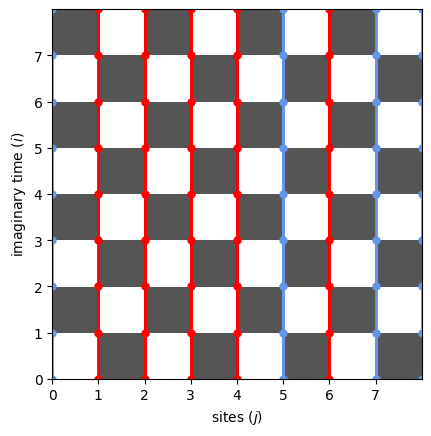

In [10]:
for _ in tqdm(range(1_000)):
    loop_update(wl, rng)
wl.draw()

In [ ]:
n_cycles = 3_000
length_cycle = 2 * pb.m * pb.n_sites
energies = np.zeros(n_cycles)
weights = np.zeros(n_cycles)

with tqdm(total=n_cycles * length_cycle, unit="step") as pbar:
    for i in range(n_cycles):
        for _ in range(length_cycle):
            loop_update(wl, rng)
            pbar.update(1)
        energies[i] = wl.compute_energy()
        weights[i] = wl.compute_weight()

  0%|          | 0/192000 [00:00<?, ?step/s]

In [ ]:
np.mean(energies)

np.float64(-33.55464441146723)

In [ ]:
np.sum(energies * weights) / np.sum(weights)

np.float64(-36.7025516452258)